In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import flatten
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

In [7]:
!pip install opencv-python

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Batch Normalization Layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 28 * 28, 1024)  # Adjust size based on image input size (224x224)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)  # Output layer for binary classification

        # Dropout layer for regularization
        self.drop = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.fc3(x)
        return x

In [11]:
def check_gpu():
    if torch.cuda.is_available():
        print("Using GPU:", torch.cuda.get_device_name(0))
    else:
        print("Using CPU")

In [13]:
def generate_grad_cam(model, input_tensor, target_class):
    model.eval()  # Set the model to evaluation mode

    # Hook the gradients of the last convolutional layer
    gradients = []
    activations = []

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    def forward_hook(module, input, output):
        activations.append(output)

    # Register hooks to the last convolutional layer
    target_layer = model.conv3  # Last convolutional layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    input_tensor = input_tensor.to(device)
    output = model(input_tensor)

    # Backward pass for the target class
    model.zero_grad()
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0][target_class] = 1
    output.backward(gradient=one_hot_output)

    # Get gradients and activations
    grad = gradients[0].cpu().detach().numpy()
    activation = activations[0].cpu().detach().numpy()

    # Compute Grad-CAM
    weights = np.mean(grad, axis=(2, 3), keepdims=True)
    cam = np.sum(weights * activation, axis=1).squeeze()
    cam = np.maximum(cam, 0)  # ReLU operation
    cam = cam / np.max(cam)  # Normalize to [0, 1]

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    return cam

In [15]:
from torchvision.transforms.functional import to_pil_image

def visualize_grad_cam(image, grad_cam, title="Grad-CAM"):
    """
    Visualize Grad-CAM with the image.
    
    Args:
        image (Tensor): Input tensor of shape (C, H, W).
        grad_cam (ndarray): Grad-CAM heatmap of shape (H, W).
        title (str): Title of the plot.
    """
    # Ensure image is in HWC format
    if image.shape[0] == 3:  # If image is (C, H, W), convert to (H, W, C)
        image = image.permute(1, 2, 0).numpy()

    grad_cam = np.uint8(255 * grad_cam)
    grad_cam = cv2.resize(grad_cam, (image.shape[1], image.shape[0]))

    # Overlay Grad-CAM on the image
    heatmap = cv2.applyColorMap(grad_cam, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(np.array(image * 255, dtype=np.uint8), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [208]:
def segment_lesion(image):
    # Convert to grayscale and apply thresholding
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Create a mask for GrabCut
    mask = np.zeros(image.shape[:2], np.uint8)
    mask[thresh == 255] = cv2.GC_FGD  # Foreground
    mask[thresh == 0] = cv2.GC_BGD    # Background

    # Initialize background and foreground models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)

    # Apply GrabCut with the mask
    cv2.grabCut(image, mask, None, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_MASK)

    # Extract the segmented region
    final_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    segmented_image = image * final_mask[:, :, np.newaxis]

    return segmented_image, final_mask

In [210]:
from PIL import Image

def get_cropped_lesion(image_path):
    """
    Extract the cropped lesion from the input image using segmentation and contour logic.

    Args:
        image_path (str): Path to the input image.

    Returns:
        PIL.Image: The cropped lesion as a PIL Image.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Error: Cannot load image at {image_path}. Check the file path or integrity.")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Use your `segment_lesion` function to segment the lesion
    segmented_image, final_mask = segment_lesion(image)

    # Find contours
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the image center
    image_center = (image.shape[1] // 2, image.shape[0] // 2)  # (cx, cy)

    # Find the closest contour
    closest_contour = None
    min_distance = float('inf')
    for contour in contours:
        moments = cv2.moments(contour)
        if moments["m00"] != 0:  # Avoid division by zero
            cx_contour = int(moments["m10"] / moments["m00"])
            cy_contour = int(moments["m01"] / moments["m00"])
            distance = np.sqrt((cx_contour - image_center[0]) ** 2 + (cy_contour - image_center[1]) ** 2)
            if distance < min_distance:
                min_distance = distance
                closest_contour = contour

    if closest_contour is None:
        raise ValueError("No valid contour found near the center.")

    # Extract the bounding box of the closest contour
    x, y, w, h = cv2.boundingRect(closest_contour)

    # Create a mask for the contour
    mask = np.zeros_like(final_mask)
    cv2.drawContours(mask, [closest_contour], -1, 255, thickness=cv2.FILLED)

    # Crop the lesion from the image
    cropped_mask = mask[y:y+h, x:x+w]
    cropped_lesion = image_rgb[y:y+h, x:x+w] * (cropped_mask[:, :, np.newaxis] > 0)

    # Convert the cropped lesion to a PIL image
    cropped_lesion_pil = Image.fromarray(cropped_lesion.astype('uint8'))

    return cropped_lesion_pil

In [212]:
image_path = "melanoma_cancer_dataset/train/benign/melanoma_1432.jpg"  # Replace with your image path
cropped_lesion = get_cropped_lesion(image_path)
cropped_lesion.show()  # Display the cropped lesion

In [214]:
from torch.utils.data import Dataset
from PIL import Image

class CroppedLesionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get image path and label
        image_path, label = self.dataset.samples[idx]
        
        # Crop lesion using the custom function
        cropped_lesion = get_cropped_lesion(image_path)  # Returns a PIL Image
        
        # Apply transformations
        if self.transform:
            cropped_lesion = self.transform(cropped_lesion)

        return cropped_lesion, label

In [216]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [218]:
from torch.utils.data import Subset

In [220]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

# Load the dataset with cropped lesions
train_data = CroppedLesionDataset(root_dir="melanoma_cancer_dataset/train", transform=transform)
val_data = CroppedLesionDataset(root_dir="melanoma_cancer_dataset/test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [222]:
model = CNN().to(device)

In [224]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [226]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    check_gpu()
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs.squeeze()) > 0.5
            correct_train += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train.double() / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {epoch_loss:.4f} - Train accuracy: {epoch_acc:.4f}")

        model.eval()
        running_val_loss = 0.0
        correct_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float())
                running_val_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(outputs.squeeze()) > 0.5
                correct_val += torch.sum(preds == labels.data)

        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val.double() / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {val_loss:.4f} - Val accuracy: {val_acc:.4f}")

In [228]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Using CPU
Epoch 1/10 - Train loss: 0.8730 - Train accuracy: 0.7480
Epoch 1/10 - Val loss: 0.3822 - Val accuracy: 0.8200
Epoch 2/10 - Train loss: 0.4450 - Train accuracy: 0.7993
Epoch 2/10 - Val loss: 0.3712 - Val accuracy: 0.8270
Epoch 3/10 - Train loss: 0.4486 - Train accuracy: 0.8004
Epoch 3/10 - Val loss: 0.3593 - Val accuracy: 0.8320
Epoch 4/10 - Train loss: 0.4177 - Train accuracy: 0.8117
Epoch 4/10 - Val loss: 0.3759 - Val accuracy: 0.8330
Epoch 5/10 - Train loss: 0.4095 - Train accuracy: 0.8168
Epoch 5/10 - Val loss: 0.3687 - Val accuracy: 0.8260
Epoch 6/10 - Train loss: 0.3972 - Train accuracy: 0.8189
Epoch 6/10 - Val loss: 0.3630 - Val accuracy: 0.8300
Epoch 7/10 - Train loss: 0.3961 - Train accuracy: 0.8199
Epoch 7/10 - Val loss: 0.3383 - Val accuracy: 0.8550
Epoch 8/10 - Train loss: 0.3906 - Train accuracy: 0.8262
Epoch 8/10 - Val loss: 0.3457 - Val accuracy: 0.8280
Epoch 9/10 - Train loss: 0.3875 - Train accuracy: 0.8322
Epoch 9/10 - Val loss: 0.3436 - Val accuracy: 0.8350


In [229]:
sample_image, sample_label = next(iter(val_loader))
sample_image = sample_image[9].unsqueeze(0)

In [230]:
print(sample_image[0].shape)  # This should be [3, height, width]

torch.Size([3, 224, 224])


In [231]:
grad_cam = generate_grad_cam(model, sample_image, target_class=0)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


/var/folders/71/2nvqjrjx53ndqspn2yc2p7d80000gn/T/ipykernel_92640/164140228.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unnormalized_image = unnormalize(torch.tensor(image))  # Unnormalize


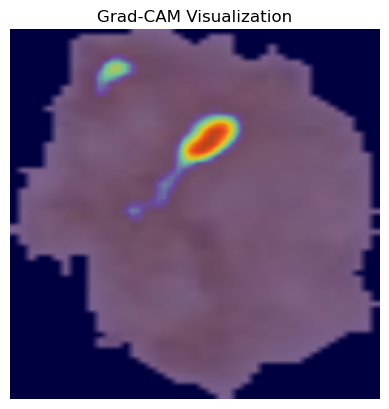

In [232]:
visualize_grad_cam(sample_image[0].cpu(), grad_cam, title="Grad-CAM Visualization")

In [233]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("Using CPU")

CUDA available: False
Using CPU


In [234]:
model_save_path = "cnn_model.pth"  # Specify the path where you want to save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to cnn_model.pth


In [235]:
torch.save(model, "cnn_model_full.pth")

In [236]:
def visualize_grad_cam(image, grad_cam, title="Grad-CAM"):
    # Normalize Grad-CAM to [0, 255] for visualization
    grad_cam = np.uint8(255 * grad_cam)

    # Ensure Grad-CAM matches the input image dimensions
    grad_cam = cv2.resize(grad_cam, (image.shape[2], image.shape[1]))

    # Unnormalize the input image
    unnormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    unnormalized_image = unnormalize(torch.tensor(image))  # Unnormalize
    unnormalized_image = unnormalized_image.numpy().transpose(1, 2, 0)  # Convert to [H, W, C]
    unnormalized_image = np.clip(unnormalized_image, 0, 1)  # Ensure values are in [0, 1]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)  # Convert to 8-bit

    # Overlay Grad-CAM on the unnormalized image
    heatmap = cv2.applyColorMap(grad_cam, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(cv2.cvtColor(unnormalized_image, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

    # Display the Grad-CAM overlay
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

In [237]:
# Define unnormalization based on the transform's mean and std
unnormalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

# Unnormalize the image
unnormalized_image = unnormalize(sample_image[0])

In [238]:
grad_cam = cv2.resize(grad_cam, (224, 224))

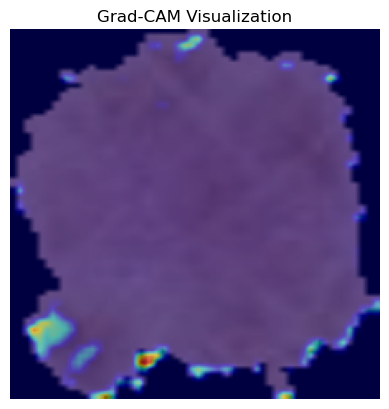

In [239]:
# Get a sample image and label
sample_image, sample_label = next(iter(val_loader))
sample_image = sample_image[0].unsqueeze(0)  # Select one image and add batch dimension

# Generate Grad-CAM
grad_cam = generate_grad_cam(model, sample_image, target_class=0)

# Visualize Grad-CAM
visualize_grad_cam(sample_image[0].cpu().numpy(), grad_cam, title="Grad-CAM Visualization")

/var/folders/71/2nvqjrjx53ndqspn2yc2p7d80000gn/T/ipykernel_92640/2184604107.py:37: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)  # Normalize to [0, 1]
/var/folders/71/2nvqjrjx53ndqspn2yc2p7d80000gn/T/ipykernel_92640/164140228.py:3: RuntimeWarning: invalid value encountered in cast
  grad_cam = np.uint8(255 * grad_cam)


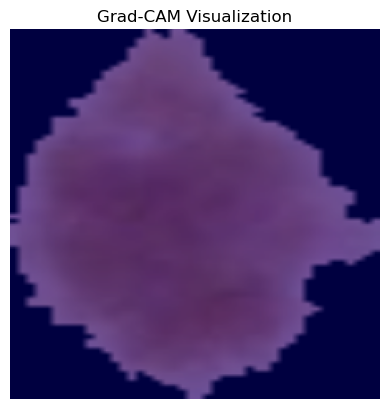

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [240]:
# Get a sample image and label
sample_image, sample_label = next(iter(val_loader))
sample_image = sample_image[20].unsqueeze(0)  # Select one image and add batch dimension

# Generate Grad-CAM
grad_cam = generate_grad_cam(model, sample_image, target_class=0)

# Visualize Grad-CAM
visualize_grad_cam(sample_image[0].cpu().numpy(), grad_cam, title="Grad-CAM Visualization")
print(sample_label)

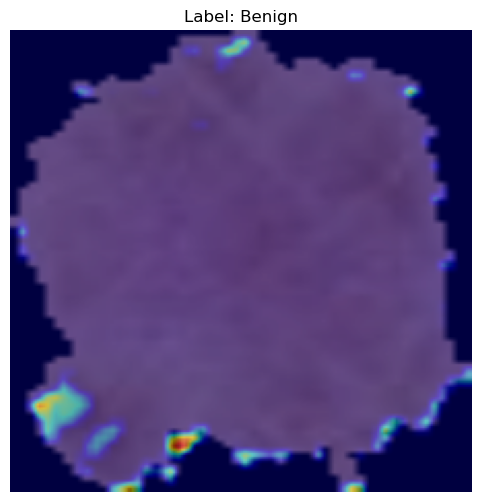

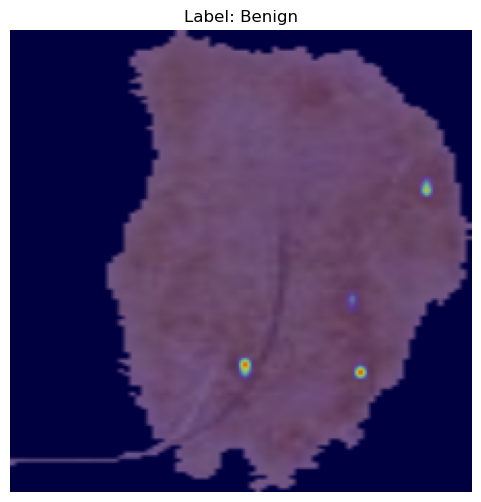

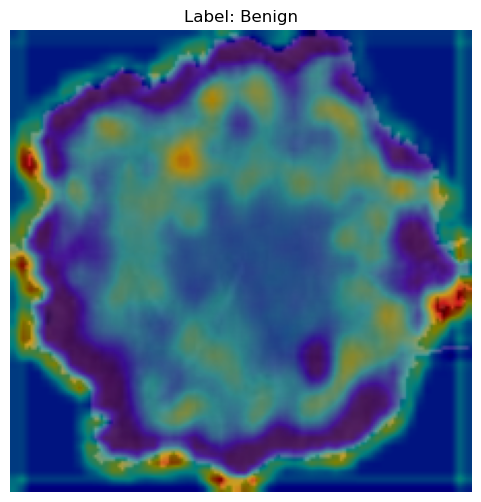

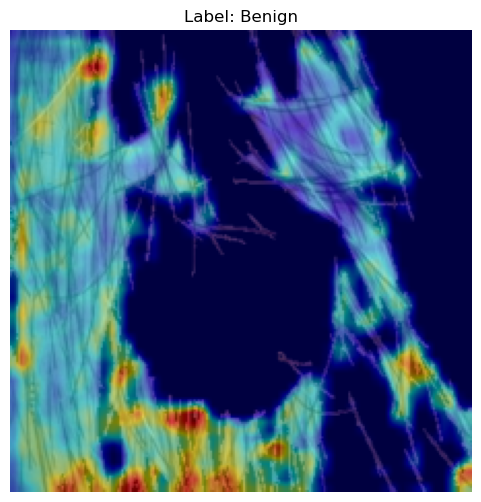

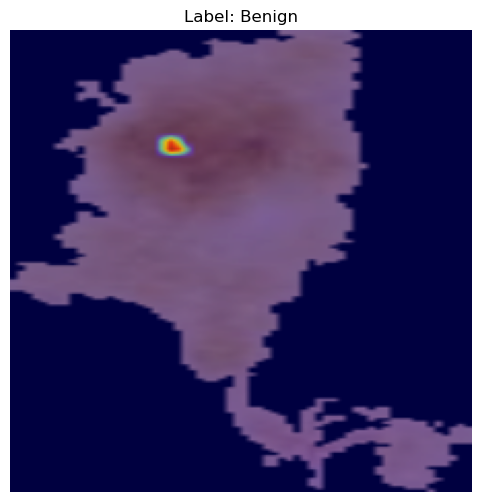

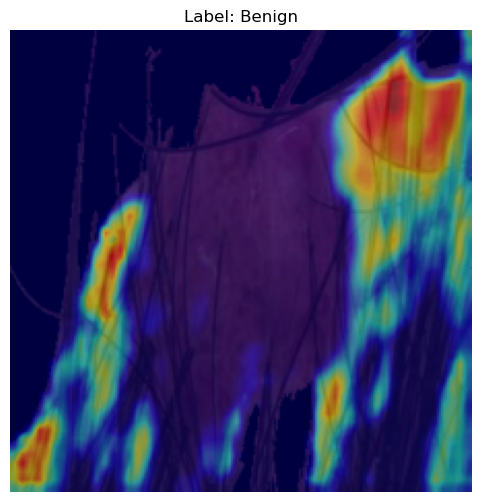

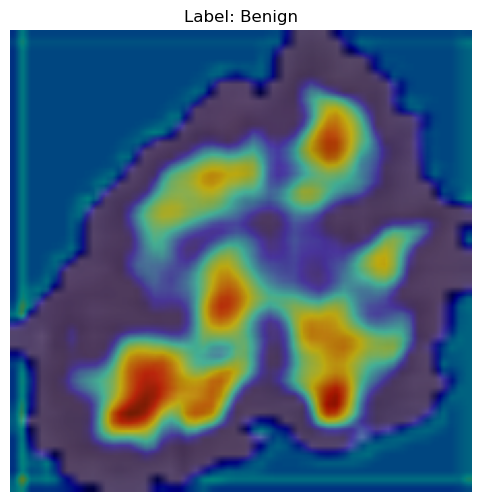

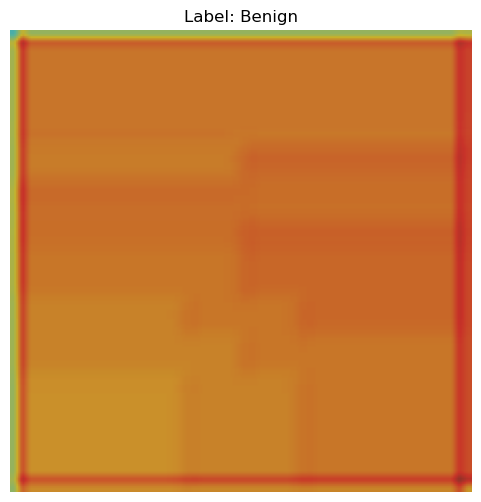

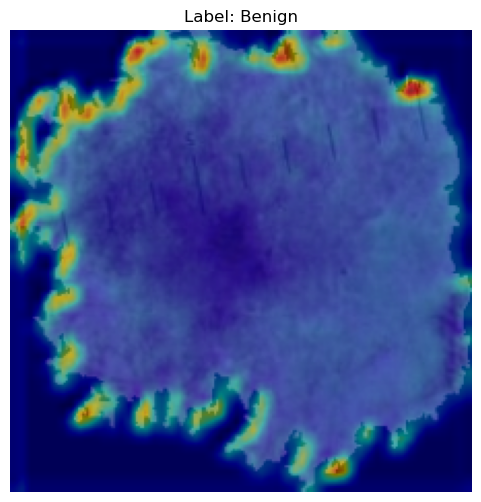

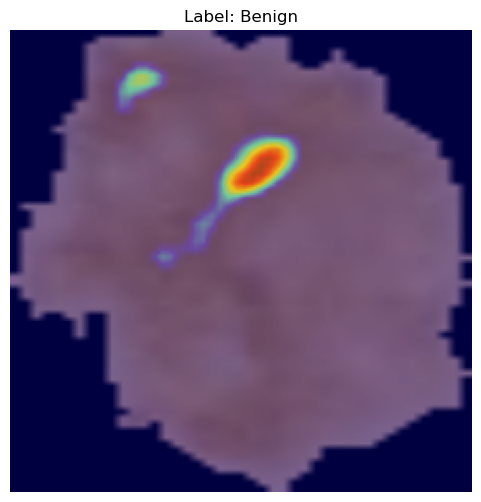

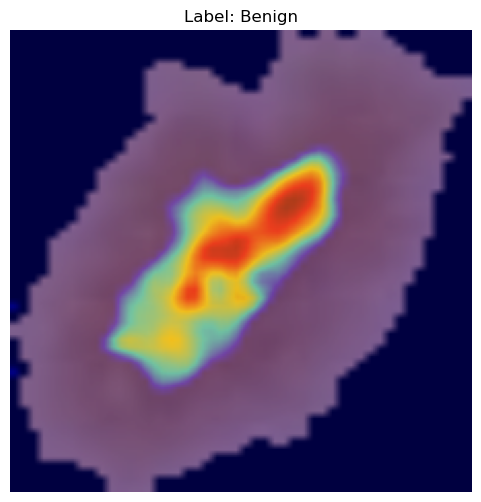

/var/folders/71/2nvqjrjx53ndqspn2yc2p7d80000gn/T/ipykernel_92640/2184604107.py:37: RuntimeWarning: invalid value encountered in divide
  cam = cam / np.max(cam)  # Normalize to [0, 1]
/var/folders/71/2nvqjrjx53ndqspn2yc2p7d80000gn/T/ipykernel_92640/3920349082.py:31: RuntimeWarning: invalid value encountered in cast
  grad_cam = np.uint8(255 * grad_cam)


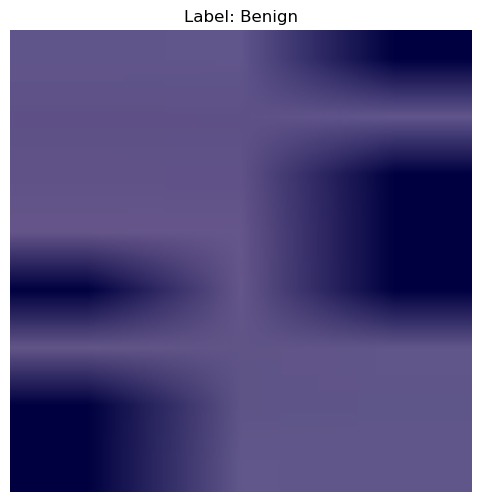

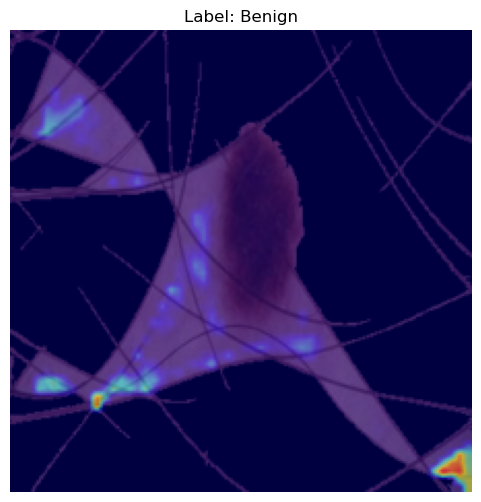

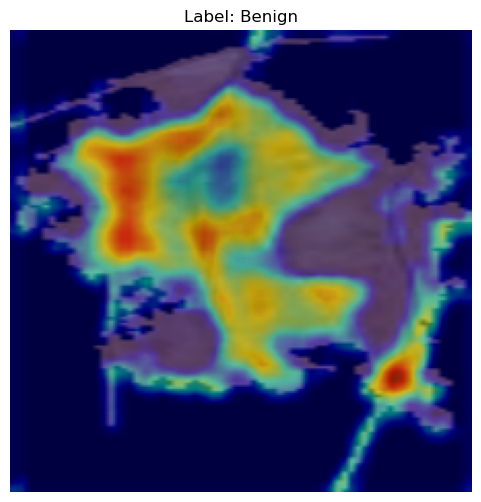

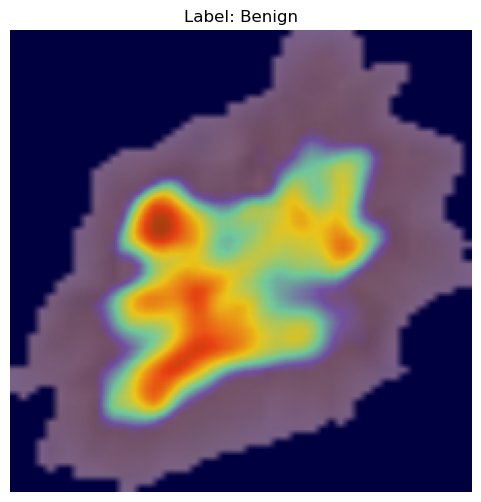

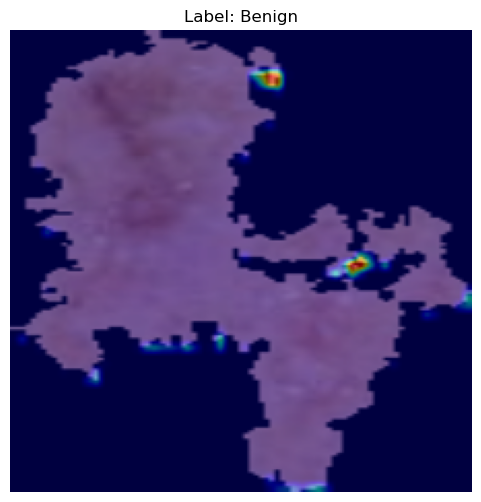

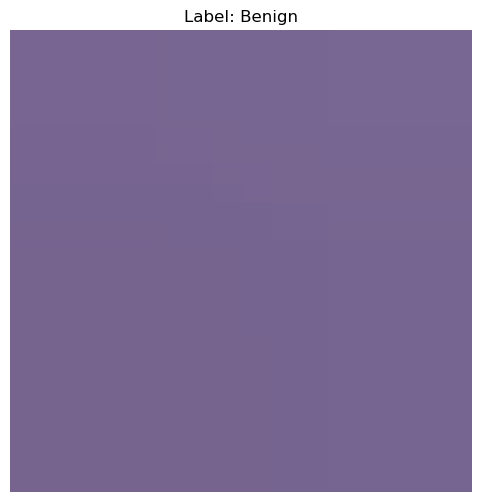

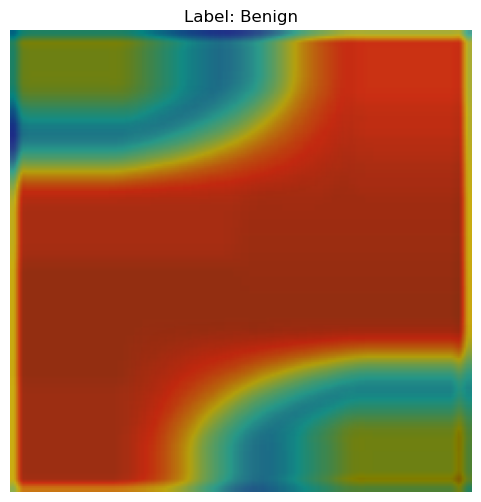

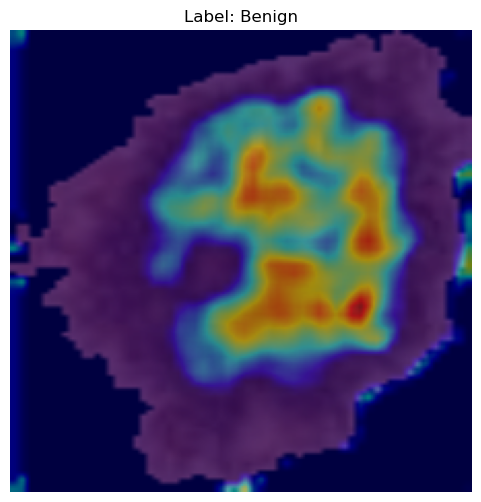

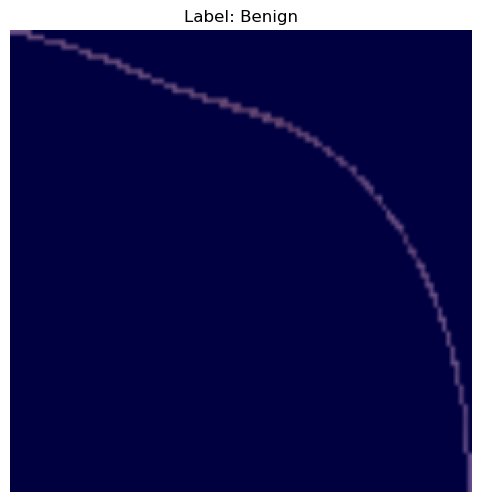

In [241]:
import matplotlib.pyplot as plt

# Function to visualize Grad-CAM with multiple images
def visualize_multiple_grad_cams(model, data_loader, num_images=5):
    model.eval()  # Set the model to evaluation mode
    unnormalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    
    count = 0
    for images, labels in data_loader:
        for i in range(images.size(0)):
            if count >= num_images:
                return
            
            # Get one image and its label
            image = images[i].unsqueeze(0).to(device)  # Add batch dimension
            label = labels[i].item()

            # Generate Grad-CAM
            grad_cam = generate_grad_cam(model, image, target_class=label)

            # Unnormalize the image
            unnormalized_image = unnormalize(images[i].cpu())
            unnormalized_image = unnormalized_image.numpy().transpose(1, 2, 0)  # Convert to [H, W, C]
            unnormalized_image = np.clip(unnormalized_image, 0, 1)  # Ensure values are in [0, 1]
            unnormalized_image = (unnormalized_image * 255).astype(np.uint8)  # Convert to 8-bit

            # Resize Grad-CAM to match the image dimensions
            grad_cam = np.uint8(255 * grad_cam)
            grad_cam = cv2.resize(grad_cam, (unnormalized_image.shape[1], unnormalized_image.shape[0]))

            # Overlay Grad-CAM on the image
            heatmap = cv2.applyColorMap(grad_cam, cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(cv2.cvtColor(unnormalized_image, cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

            # Display the image with Grad-CAM
            plt.figure(figsize=(6, 6))
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title(f"Label: {'Malignant' if label == 1 else 'Benign'}")
            plt.axis("off")
            plt.show()

            count += 1

# Visualize the first 5 images
visualize_multiple_grad_cams(model, val_loader, num_images=20)

In [242]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the saved model
model = torch.load("cnn_model_full.pth")
model.eval()  # Set the model to evaluation mode

# Define the transformation (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization
])

# Function to preprocess and predict for a single image
def predict_single_image(image_path):
    # Load the image
    image = Image.open(image_path).convert("RGB")  # Ensure 3-channel RGB
    # Apply the transformations
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move to the same device as the model (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    input_tensor = input_tensor.to(device)

    # Run the model
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.sigmoid(output).cpu().item()  # Assuming binary classification

    # Convert prediction to label
    label = "Malignant" if prediction > 0.5 else "Benign"
    return label, prediction

# Test with a single image
image_path = "melanoma_cancer_dataset/train/malignant/melanoma_5006.jpg"  # Replace with the path to your test image
label, score = predict_single_image(image_path)

print(f"Prediction: {label} (Score: {score:.4f})")

Prediction: Malignant (Score: 0.6273)


/var/folders/71/2nvqjrjx53ndqspn2yc2p7d80000gn/T/ipykernel_92640/1479445208.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("cnn_model_full.pth")


In [243]:
image_path = "melanoma_cancer_dataset/Screenshot 2024-12-04 at 16.23.02.png"  # Replace with the path to your test image
label, score = predict_single_image(image_path)

print(f"Prediction: {label} (Score: {score:.4f})")

Prediction: Benign (Score: 0.3358)
